In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import datetime


from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell


In [2]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df, val_df, test_df,
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result
    

In [3]:
url_train = 'https://raw.githubusercontent.com/xbadiam/Forecasting/refs/heads/main/data/output/train.csv'
train_df = pd.read_csv(url_train, index_col=0)
train_df.head(5)

,clouds_all,traffic_volume,day_sin,day_cos
temp,,,,
0.760019,0.0,0.758755,0.146447,0.146447
0.738174,0.0,0.560765,0.066987,0.250000
0.698884,0.0,0.463513,0.017037,0.370590
0.668238,0.0,0.370029,0.000000,0.500000
0.643093,0.0,0.325101,0.017037,0.629410


In [4]:
url_val = 'https://raw.githubusercontent.com/xbadiam/Forecasting/refs/heads/main/data/output/val.csv'
val_df = pd.read_csv(url_val, index_col=0)
val_df.head(5)

,clouds_all,traffic_volume,day_sin,day_cos
temp,,,,
0.457646,0.01,0.700153,0.370590,0.017037
0.460946,0.20,0.769918,0.250000,0.066987
0.459375,0.05,0.872750,0.146447,0.146447
0.456388,0.20,0.776894,0.066987,0.250000
0.440830,0.05,0.664574,0.017037,0.370590


In [5]:
url_test = 'https://raw.githubusercontent.com/xbadiam/Forecasting/refs/heads/main/data/output/test.csv'
test_df = pd.read_csv(url_test, index_col=0)
test_df.head(5)

,clouds_all,traffic_volume,day_sin,day_cos
temp,,,,
0.767405,0.9,0.401563,0.000000,0.500000
0.756876,0.9,0.348821,0.017037,0.629410
0.754833,0.9,0.302637,0.066987,0.750000
0.754833,0.9,0.187108,0.146447,0.853553
0.756247,0.9,0.080926,0.250000,0.933013


In [6]:
train_df = train_df.reset_index()
val_df   = val_df.reset_index()
test_df  = test_df.reset_index()

## Implementing a single-step linear model

We simply take all the inputs, assign a weight to each, take the sum, and generate a prediction. Remember that we are using the traffic volume as a target.

Unlike a baseline model, a linear model actually requires training. Thus, we'll define a compile_and_fit function that configures the model for training and then fits the model on the data, as shown in the following listing.

We'll use the Sequential model from Keras, as it allows us to stack different layers. Since we are building a linear model here, we only have one layer—a Dense layer, which is the most basic layer in deep learning. We’ll specify the number of units as 1, since the model must output only one value: the prediction for traffic volume at the next timestep.

In [7]:
linear = Sequential([
    Dense(units=1)
])

In [8]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    """
    function that configures the model for training and then fits the model on the data, as 
    shown in the following listing.
        
    :param model: Model to be compiled and trained.
    :param window: An instance of the DataWindow class containing training and validation data.
    :param patience: Number of epochs with no improvement after which training will be stopped.
    :param max_epochs: sets amaximum number of epochs to train the model.
    """
        
    # Early stopping occurs if 3 consecutive epochs do not decrease 
    # # the validation loss, as set by the patience parameter.
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
        
    # The MSE is used as the loss function.
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
        
    # The model is fit using the training data from the window object.
    history = model.fit(window.train,
                        epochs=max_epochs,
                        validation_data=window.val,
                        callbacks=[early_stopping])
        
    return history

Clearly, Keras makes it very easy to build models. With this step complete, we can then train the model using compile_and_fit and store the performance to later compare it to the baseline.

In [11]:
single_step_window = DataWindow(input_width=1, 
                                label_width=1, 
                                shift=1, 
                                label_columns=['traffic_volume'], 
                                train_df=train_df, val_df=val_df, test_df=test_df)


wide_window = DataWindow(input_width=24, 
                         label_width=24, 
                         shift=1,
                         label_columns=['traffic_volume'],
                         train_df=train_df, val_df=val_df, test_df=test_df)

In [10]:
val_performance = {}
performance = {}

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.6062 - mean_absolute_error: 1.1152 - val_loss: 0.3477 - val_mean_absolute_error: 0.4851
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3072 - mean_absolute_error: 0.4532 - val_loss: 0.1872 - val_mean_absolute_error: 0.3600
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1578 - mean_absolute_error: 0.3280 - val_loss: 0.1422 - val_mean_absolute_error: 0.3107
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1116 - mean_absolute_error: 0.2735 - val_loss: 0.1040 - val_mean_absolute_error: 0.2649
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0804 - mean_absolute_error: 0.2298 - val_loss: 0.0775 - val_mean_absolute_error: 0.2284
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0601 - mean_absolute_error: 0.1967 - val_loss: 0.0596 - val_mean_absolute_error: 0.1996
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0467 - mean_absolute_error: 0.1720 - v

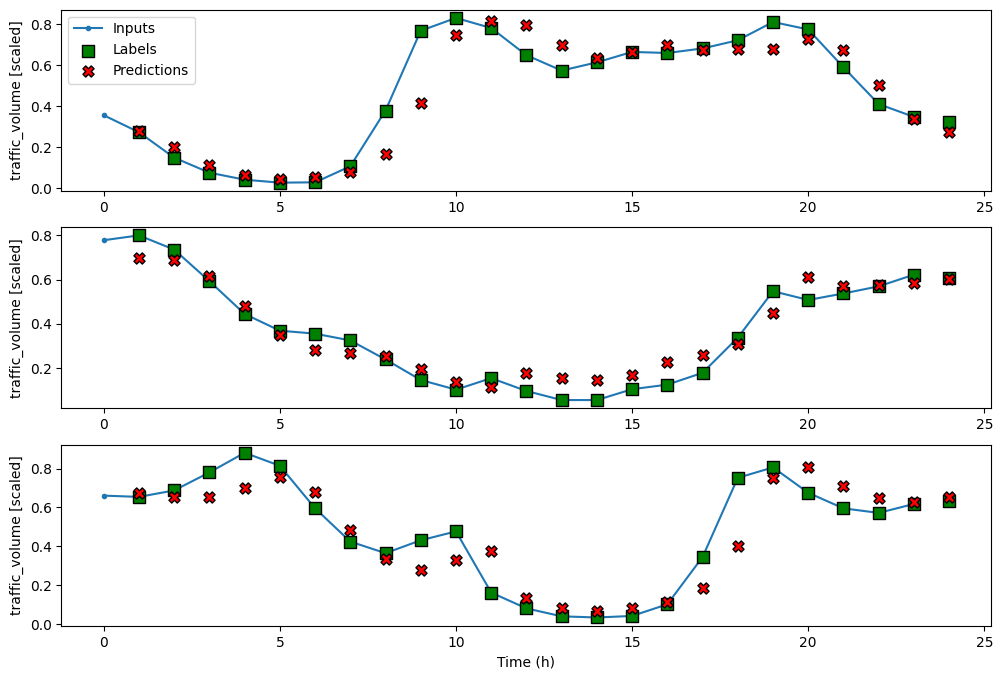

In [12]:
wide_window.plot(linear)

Predictions of traffic volume using the linear model as a single-step model. The predictions (shown as crosses) are fairly accurate, with some predictions overlapping the actual values (shown as squares).

## Implementing a multi-step linear model

Our single-step linear model is built, and we can now extend it to a multi-step linear model. Recall that in the multi-step situation, we wish to predict the next 24 hours of data using an input window of 24 hours of data. Our target remains the traffic volume.

This model will greatly resemble the single-step linear model, but this time we’ll use 24 hours of input and output 24 hours of predictions.

Implementing the model is easy, as our model only contains a single Dense layer. We can optionally initialize the weights to 0, which makes the training procedure slightly faster. We then compile and fit the model before storing its evaluation metrics in ms_val_performance and ms_performance.

In [13]:
multi_window = DataWindow(input_width=24, 
                          label_width=24, 
                          shift=24, 
                          label_columns=['traffic_volume'],
                          train_df=train_df, val_df=val_df, test_df=test_df)

In [14]:
ms_val_performance = {}
ms_performance = {}

ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear, multi_window)

ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1413 - mean_absolute_error: 0.3089 - val_loss: 0.0405 - val_mean_absolute_error: 0.1670
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0328 - mean_absolute_error: 0.1475 - val_loss: 0.0238 - val_mean_absolute_error: 0.1194
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0208 - mean_absolute_error: 0.1104 - val_loss: 0.0206 - val_mean_absolute_error: 0.1064
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0181 - mean_absolute_error: 0.0994 - val_loss: 0.0195 - val_mean_absolute_error: 0.1009
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0171 - mean_absolute_error: 0.0939 - val_loss: 0.0189 - val_mean_absolute_error: 0.0969
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0165 - mean_absolute_error: 0.0903 - val_loss: 0.0185 - val_mean_absolute_error: 0.0937
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0162 - mean_absolute_error: 0.0877 - v

## Implementing a multi-output linear model

The multi-output linear model will return predictions for the traffic volume and the temperature. The input is the present timestep, and the predictions are for the next timestep.

Up to this point, we have only predicted the traffic volume, meaning that we had only one target, so we used the layer Dense(units=1). In this case, since we must output a prediction for two targets, our layer will be Dense(units=2).

In [17]:
mo_single_step_window = DataWindow(input_width=1, 
                                   label_width=1, 
                                   shift=1,
                                   label_columns=['temp','traffic_volume'],
                                   train_df=train_df, val_df=val_df, test_df=test_df)

mo_wide_window = DataWindow(input_width=24, 
                            label_width=24, 
                            shift=1,
                            label_columns=['temp','traffic_volume'],
                            train_df=train_df, val_df=val_df, test_df=test_df)

In [18]:
mo_val_performance = {}
mo_performance = {}

mo_linear = Sequential([
    # We set units equal to the number of targets we are predicting in
    # the output layer.
    Dense(units=2)
])

history = compile_and_fit(mo_linear, mo_single_step_window)

mo_val_performance['Linear'] =mo_linear.evaluate(mo_single_step_window.val)
mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.0815 - mean_absolute_error: 0.8848 - val_loss: 0.2999 - val_mean_absolute_error: 0.4450
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2090 - mean_absolute_error: 0.3788 - val_loss: 0.1225 - val_mean_absolute_error: 0.2954
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1000 - mean_absolute_error: 0.2645 - val_loss: 0.0641 - val_mean_absolute_error: 0.2075
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0531 - mean_absolute_error: 0.1861 - val_loss: 0.0336 - val_mean_absolute_error: 0.1458
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0281 - mean_absolute_error: 0.1312 - val_loss: 0.0188 - val_mean_absolute_error: 0.1045
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0164 - mean_absolute_error: 0.0968 - val_loss: 0.0122 - val_mean_absolute_error: 0.0794
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0113 - mean_absolute_error: 0.0773 - v

With our single-step, multi-step, and multi-output linear models done, we can now move on to implementing a more complex architecture: a deep neural network.